In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)
pd.set_option('display.max_rows',50)
pd.options.mode.chained_assignment = None

import random
random.seed(68)

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=20)

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors


INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
import sys
sys.path.append('../')
from Draw_fig import Draw_plot
from standardization_process import *

In [3]:
def process_stage_1(df,smi_col):
    df[smi_col] = df[smi_col].parallel_apply(smi_to_smi)
    df = df[~df[smi_col].isna()]
    df = smiles_check(df , smi_col)
    df = df[df['Smiles_check'] != False]
    df = remove_salt(df, smi_col)
    metal_index = metal_check(df, 'Smiles_removesalt')
    df = df[~df.index.isin(metal_index)]
    df = smiles_unify(df, 'Smiles_removesalt')
    return df 

# Summary for the raw data

In [4]:
Chembl = pd.read_csv('../data/data_mining_results/Cytochrome_P450_enzymes/chembl_cyp_data_mining_finished.csv')

In [6]:
Chembl = Chembl[~Chembl['Cytochrome_P450_enzymes'].isna()]
Chembl.shape

(14775, 26)

In [8]:
Chembl['Assay ChEMBL ID'].nunique()

3651

# Chembl

In [9]:
chembl = pd.read_csv('../data/data_mining_results/Cytochrome_P450_enzymes/chembl_cyp_data_mining_finished.csv')

In [10]:
chembl.shape

(19930, 26)

In [11]:
chembl.head(3)

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Document ChEMBL ID,Source Description,Document Journal,Document Year,Enzyme Source,Incubation Time,Temperature Range,pH Level,Substrate Concentration,Inhibitor Concentration,Cofactors,Detection Method,Protein Expression System,CYP sources,Cytochrome_P450_enzymes
0,CHEMBL1294,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,IC50,'=',20.0,nM,CHEMBL860948,Inhibition of human CYP2D6,A,BAO_0000357,single protein format,CHEMBL1146077,Scientific Literature,J Med Chem,2006.0,CYP2D6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,human,True
1,CHEMBL495118,CNc1noc2c(-c3ccc4c(N5CCOC[C@@H]5C)nncc4c3)c(Cl...,IC50,'=',6000.0,nM,CHEMBL1035787,Inhibition of CYP3A4 in human liver microsomes,A,BAO_0000251,microsome format,CHEMBL1140162,Scientific Literature,J Med Chem,2008.0,CYP3A4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,human liver microsomes,True
2,CHEMBL206202,CC[C@@](C)(Cc1ccc(OCCCOc2ccc(CC(F)(F)F)cc2Cl)c...,IC50,'<',50.0,nM,CHEMBL868415,Inhibition of CYP2C9,A,BAO_0000357,single protein format,CHEMBL1139027,Scientific Literature,Bioorg Med Chem Lett,2006.0,CYP2C9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


## check experimental data

In [12]:
chembl['Cytochrome_P450_enzymes'] = chembl['Cytochrome_P450_enzymes'].fillna(False)
chembl = chembl[chembl['Cytochrome_P450_enzymes']]
chembl = chembl[chembl['Standard Relation'] == "'='"]

In [13]:
chembl.columns

Index(['Molecule ChEMBL ID', 'Smiles', 'Standard Type', 'Standard Relation',
       'Standard Value', 'Standard Units', 'Assay ChEMBL ID',
       'Assay Description', 'Assay Type', 'BAO Format ID', 'BAO Label',
       'Document ChEMBL ID', 'Source Description', 'Document Journal',
       'Document Year', 'Enzyme Source', 'Incubation Time',
       'Temperature Range', 'pH Level', 'Substrate Concentration',
       'Inhibitor Concentration', 'Cofactors', 'Detection Method',
       'Protein Expression System', 'CYP sources', 'Cytochrome_P450_enzymes'],
      dtype='object')

In [14]:
for experiment in [ 'Enzyme Source', 'Incubation Time',
       'Temperature Range', 'pH Level', 'Substrate Concentration',
       'Inhibitor Concentration', 'Cofactors', 'Detection Method',
       'Protein Expression System', 'CYP sources']:
    display(chembl[experiment].value_counts(dropna=False))

CYP3A4                2201
CYP2D6                1287
CYP2C9                1053
CYP11B2                615
CYP1A2                 545
                      ... 
recombinant CYP2D6       4
SCD                      3
hepatic CYP3A4           3
CYP450                   2
CYP2B1                   2
Name: Enzyme Source, Length: 66, dtype: int64

NaN                                                            6399
after 10 mins                                                   178
after 45 mins                                                   114
after 30 mins                                                   111
preincubated for 5 mins                                          95
                                                               ... 
preincubated for 5 mins, after NADPH addition                     3
preincubated for 30 mins, after substrate addition                3
preincubated for 10 mins, measured every minute for 10 mins       1
after 4 mins                                                      1
incubated for 40 to 130 mins                                      1
Name: Incubation Time, Length: 109, dtype: int64

NaN                                           8460
37 degC                                         24
room temperature, overnight shaking at 4 C      17
at 37°C                                         10
Name: Temperature Range, dtype: int64

NaN       8471
pH 7.5      23
pH 7.2      17
Name: pH Level, dtype: int64

NaN                                         5165
7-ethoxyresorufin                            202
[1,2-3H]-11-deoxycorticosterone              195
testosterone                                 160
3-Cyano-7-ethoxycoumarin                     155
                                            ... 
7-benzyloxyresorufin                           1
diethoxyfluorescein/7-benzyloxyquinoline       1
acetaminophen                                  1
benzyloxy-4-(trifluoromethyl)coumarin          1
p-nitrophenol                                  1
Name: Substrate Concentration, Length: 128, dtype: int64

NaN                                                                   8122
in presence of NADPH                                                   123
100 nM                                                                  68
in presence of NADPH regeneration system                                51
500 nM                                                                  49
in presence of NADP+                                                    20
relative to control                                                     18
in presence of rat P450 reductase                                       13
in presence of 250 nM 11-deoxycortisol                                   9
in presence of 1 mmol NADPH                                              9
in presence of Adx, AdR                                                  8
in presence of bovine adrenodoxin, adrenodoxin reductase and NADPH       7
in presence of NADPH/NADPH-cytochrome p450 reductase                     6
in presence of NADPH-gene

NaN                                                                                7695
NADPH                                                                               546
NADPH-regenerating system                                                            65
NADPH regeneration system                                                            58
NADPH-P450 reductase                                                                 43
NADP+                                                                                24
NADP                                                                                 22
cytochrome P450 reductase                                                            22
bovine adrenodoxin, adrenodoxin reductase, NADPH                                     11
glucose-6-phosphate, glucose-6-phosphate dehydrogenase, NADPH                        11
NADPH-cytochrome p450 reductase                                                       7
glucose-6-phosphate, glucose-6-p

NaN                             5398
fluorescence assay               329
LC-MS/MS                         313
HPLC                             230
DRUGMATRIX                       188
                                ... 
CYP450-Glo assay                   3
HPLC/MS                            3
P450 cypex assay                   2
spectrofluorimetric analysis       2
CYPEX assay                        1
Name: Detection Method, Length: 95, dtype: int64

NaN                                           4281
human liver microsomes                         627
recombinant human                              487
unknown origin                                 281
recombinant                                    269
                                              ... 
expressed in insect microsomes                   3
expressed in microsomes                          2
recombinant human expressed in baculosomes       1
expressed in supersomes                          1
Sprague-Dawley rat liver microsomes              1
Name: Protein Expression System, Length: 135, dtype: int64

human                       2450
NaN                         2172
unknown origin               986
recombinant human            596
human liver                  556
                            ... 
human recombinant CYP2D6       1
recombinant human CYP2D6       1
CYP2D6                         1
unknown origin CYP450          1
CYP450                         1
Name: CYP sources, Length: 82, dtype: int64

In [15]:
chembl['Enzyme Source'] = chembl['Enzyme Source'].fillna('unknown')
chembl = chembl[chembl['Enzyme Source'].isin(['CYP3A4','CYP2D6','CYP2C9'])]
chembl.shape

(4541, 26)

In [16]:
chembl = process_stage_1(chembl,'Smiles')

100%|█████████████████████████████████████████| 4541/4541 [00:00<00:00, 9023.49it/s]


SANITIZE_NONE    4541
Name: Smiles_check, dtype: int64


100%|███████████████████████████████████████| 4541/4541 [00:00<00:00, 953222.28it/s]
4541it [00:04, 1018.00it/s]


Metal in Smiles amount: 0


100%|█████████████████████████████████████████| 4541/4541 [00:00<00:00, 9775.80it/s]


In [17]:
chembl['value'] = chembl['Standard Value']
chembl['unit'] = chembl['Standard Units']

In [18]:
def standardlise_value(x):
    if x['unit'] == 'uM':
        return x['value']
    else:
        return x['value']/1000

chembl['value_uM'] = chembl.apply(standardlise_value,axis=1) 

In [19]:
chembl = chembl[chembl['value_uM'] != 0]

In [20]:
chembl['value_uM_log'] = chembl['value_uM'].apply(lambda x: round(np.log10(x), 4))

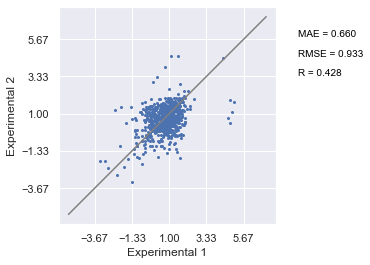

In [21]:
plot_diagram(chembl,['Smiles_unify'],'value_uM_log')

In [22]:

chembl['Enzyme Source'].value_counts(dropna=False)

CYP3A4    2200
CYP2D6    1287
CYP2C9    1053
Name: Enzyme Source, dtype: int64

In [23]:
chembl['Incubation Time'] = chembl['Incubation Time'].fillna('unknown')
chembl = chembl[~chembl['Incubation Time'].isin(['measured immediately','after 30 secs'])]
chembl['Incubation Time'].value_counts()

unknown                                                        3764
after 30 mins                                                    87
after 45 mins                                                    86
after 10 mins                                                    66
30 mins                                                          58
preincubated for 5 mins                                          57
10 mins                                                          35
preincubated for 30 mins                                         35
preincubated for 10 mins, measured after 30 mins                 33
45 mins                                                          33
after 5 mins                                                     25
pre-incubated 30 mins                                            24
after 20 mins                                                    14
after 8 mins                                                     13
incubated for 5 mins                            

In [24]:
chembl['Temperature Range'] = chembl['Temperature Range'].fillna('unknown')
chembl['Temperature Range'].value_counts()

unknown    4531
Name: Temperature Range, dtype: int64

In [25]:
chembl['pH Level'] = chembl['pH Level'].fillna('unknown')
chembl['pH Level'].value_counts()

unknown    4531
Name: pH Level, dtype: int64

In [26]:
chembl['Inhibitor Concentration'] = chembl['Inhibitor Concentration'].fillna('unknown')
chembl['Inhibitor Concentration'].value_counts()

unknown                                                              4418
in presence of NADPH                                                   54
in presence of NADPH regeneration system                               43
in presence of 1 mmol NADPH                                             9
in presence of NADPH-generating system, G6P and G6P dehydrogenase       6
NADPH                                                                   1
Name: Inhibitor Concentration, dtype: int64

In [27]:
chembl['Cofactors'] = chembl['Cofactors'].fillna('unknown')
chembl['Cofactors'].value_counts()

unknown                      4232
NADPH                         222
NADPH regeneration system      40
NADP                           22
NADPH-regenerating system      15
Name: Cofactors, dtype: int64

In [28]:
chembl['CYP sources'] = chembl['CYP sources'].fillna('unknown')
chembl['CYP sources'].value_counts()

unknown                                   1751
unknown origin                             758
human                                      671
recombinant human                          335
human liver                                331
human recombinant                          259
human liver microsomes                     245
recombinant                                 36
microsomal                                  22
human liver microsome                       19
in microsomes                               16
human liver CYP3A4                          12
CYP3A4                                       9
human hepatic                                8
recombinant human CYP3A4                     7
C-terminal 4His-tagged CYP3A4                6
unknown origin CYP3A4                        5
recombinant (unknown origin)                 5
insect cells infected with baculovirus       4
human liver CYP2D6                           4
hepatic CYP2D6                               3
unknown origi

In [29]:
chembl['Protein Expression System'] = chembl['Protein Expression System'].fillna('unknown')
chembl['Protein Expression System'].value_counts()

unknown                                                             3090
human liver microsomes                                               449
recombinant human                                                    237
recombinant                                                          204
unknown origin                                                       200
expressed in baculovirus-infected insect microsomes                   29
expressed in Escherichia coli JM109                                   25
in microsomes                                                         24
expressed in insect cells microsomes                                  23
human recombinant                                                     21
expressed in Saccharomyces cerevisiae                                 19
expressed in Escherichia coli                                         17
expressed in Saccharomyces cerevisiae YY7 microsomal membranes        16
recombinant human in supersomes                    

In [30]:
chembl.loc[chembl['Standard Units'] == 'min', 'Standard Units'] = 'uM'

In [31]:
chembl['Standard Relation'].value_counts(dropna=False)

'='    4531
Name: Standard Relation, dtype: int64

In [32]:
chembl['Standard Type'].value_counts(dropna=False)

IC50    4531
Name: Standard Type, dtype: int64

In [33]:
chembl

,Molecule ChEMBL ID,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,Assay ChEMBL ID,Assay Description,Assay Type,BAO Format ID,BAO Label,Document ChEMBL ID,Source Description,Document Journal,Document Year,Enzyme Source,Incubation Time,Temperature Range,pH Level,Substrate Concentration,Inhibitor Concentration,Cofactors,Detection Method,Protein Expression System,CYP sources,Cytochrome_P450_enzymes,Smiles_check,Smiles_removesalt,Smiles_unify,value,unit,value_uM,value_uM_log
0,CHEMBL1294,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,IC50,'=',20.0,nM,CHEMBL860948,Inhibition of human CYP2D6,A,BAO_0000357,single protein format,CHEMBL1146077,Scientific Literature,J Med Chem,2006.0,CYP2D6,unknown,unknown,unknown,NaN,unknown,unknown,NaN,unknown,human,True,SANITIZE_NONE,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,20.0,nM,0.0200,-1.6990
1,CHEMBL495118,CNc1noc2c(-c3ccc4c(N5CCOC[C@@H]5C)nncc4c3)c(Cl...,IC50,'=',6000.0,nM,CHEMBL1035787,Inhibition of CYP3A4 in human liver microsomes,A,BAO_0000251,microsome format,CHEMBL1140162,Scientific Literature,J Med Chem,2008.0,CYP3A4,unknown,unknown,unknown,NaN,unknown,unknown,NaN,unknown,human liver microsomes,True,SANITIZE_NONE,CNc1noc2c(-c3ccc4c(N5CCOC[C@@H]5C)nncc4c3)c(Cl...,CNc1noc2c(-c3ccc4c(N5CCOC[C@@H]5C)nncc4c3)c(Cl...,6000.0,nM,6.0000,0.7782
6,CHEMBL206145,Cc1cc2c(F)c(Oc3ncnn4cc(OCCC5CCN(C)CC5)c(C)c34)...,IC50,'=',700.0,nM,CHEMBL859789,Inhibitory activity against CYP3A4,A,BAO_0000357,single protein format,CHEMBL1146078,Scientific Literature,J Med Chem,2006.0,CYP3A4,unknown,unknown,unknown,NaN,unknown,unknown,NaN,unknown,unknown,True,SANITIZE_NONE,Cc1cc2c(F)c(Oc3ncnn4cc(OCCC5CCN(C)CC5)c(C)c34)...,Cc1cc2c(F)c(Oc3ncnn4cc(OCCC5CCN(C)CC5)c(C)c34)...,700.0,nM,0.7000,-0.1549
11,CHEMBL408443,Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)OC(=O)[C@H](...,IC50,'=',24000.0,nM,CHEMBL935253,Inhibition of human CYP2D6,A,BAO_0000357,single protein format,CHEMBL1141628,Scientific Literature,J Med Chem,2008.0,CYP2D6,unknown,unknown,unknown,NaN,unknown,unknown,NaN,unknown,human,True,SANITIZE_NONE,Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)OC(=O)[C@H](...,Cc1cc2c(F)c(Oc3ncnn4cc(OC[C@@H](C)OC(=O)[C@H](...,24000.0,nM,24.0000,1.3802
12,CHEMBL377500,O=C(Nc1nccs1)N1CCC(Cc2c[nH]cn2)CC1,IC50,'=',2000.0,nM,CHEMBL866475,Inhibition of CYP2D6 by human liver microsome ...,A,BAO_0000221,tissue-based format,CHEMBL1138111,Scientific Literature,Bioorg Med Chem Lett,2006.0,CYP2D6,unknown,unknown,unknown,NaN,unknown,unknown,human liver microsome assay,unknown,human,True,SANITIZE_NONE,O=C(Nc1nccs1)N1CCC(Cc2c[nH]cn2)CC1,O=C(Nc1nccs1)N1CCC(Cc2c[nH]cn2)CC1,2000.0,nM,2.0000,0.3010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19913,CHEMBL1271763,CC1([C@@H]2COC[C@H](COC(=O)N3CCC(CO)CC3)N2S(=O...,IC50,'=',5.5,nM,CHEMBL1273059,Inhibition of CYP3A4 after 30 mins,A,BAO_0000357,single protein format,CHEMBL1268982,Scientific Literature,Bioorg Med Chem Lett,2010.0,CYP3A4,30 mins,unknown,unknown,NaN,unknown,unknown,NaN,unknown,unknown,True,SANITIZE_NONE,CC1([C@@H]2COC[C@H](COC(=O)N3CCC(CO)CC3)N2S(=O...,CC1([C@@H]2COC[C@H](COC(=O)N3CCC(CO)CC3)N2S(=O...,5.5,nM,0.0055,-2.2596
19920,CHEMBL1642915,CN[C@@H]1CCc2ccccc2[C@@H]1c1ccc(Cl)c(Cl)c1,IC50,'=',7600.0,nM,CHEMBL1647133,Inhibition of CYP2C9,A,BAO_0000357,single protein format,CHEMBL1641414,Scientific Literature,Bioorg Med Chem,2011.0,CYP2C9,unknown,unknown,unknown,NaN,unknown,unknown,NaN,unknown,unknown,True,SANITIZE_NONE,CN[C@@H]1CCc2ccccc2[C@@H]1c1ccc(Cl)c(Cl)c1,CN[C@@H]1CCc2ccccc2[C@@H]1c1ccc(Cl)c(Cl)c1,7600.0,nM,7.6000,0.8808
19926,CHEMBL1289515,O=c1cc(OCc2ccccc2)ccn1-c1ccc2c(cnn2CCN2CC[C@H]...,IC50,'=',7700.0,nM,CHEMBL1292297,Inhibition of CYP3A4,A,BAO_0000357,single protein format,CHEMBL1287684,Scientific Literature,Bioorg Med Chem Lett,2010.0,CYP3A4,unknown,unknown,unknown,NaN,unknown,unknown,NaN,unknown,unknown,True,SANITIZE_NONE,O=c1cc(OCc2

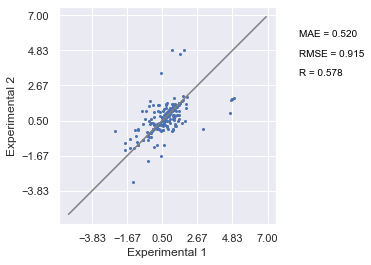

In [34]:
plot_diagram(chembl,['Smiles_unify','Enzyme Source'],'value_uM_log')

## be ready for concat

In [35]:
chembl['source'] = 'ChEMBL'
chembl['property'] = 'cyp_IC50'

In [36]:
chembl_fc = chembl[['Smiles', 'Standard Value', 'Standard Units', 
                    'Document ChEMBL ID', 'source', 
                    'Enzyme Source', 
                    'property'
                   ]]

In [37]:
chembl_fc.columns = ['Smiles', 'value', 'unit', 
                    'ref', 'source', 
                    'CYP_type', 
                    'property']

In [38]:
chembl_fc.head(3)

,Smiles,value,unit,ref,source,CYP_type,property
0,C=C[C@H]1CN2CC[C@H]1C[C@@H]2[C@@H](O)c1ccnc2cc...,20.0,nM,CHEMBL1146077,ChEMBL,CYP2D6,cyp_IC50
1,CNc1noc2c(-c3ccc4c(N5CCOC[C@@H]5C)nncc4c3)c(Cl...,6000.0,nM,CHEMBL1140162,ChEMBL,CYP3A4,cyp_IC50
6,Cc1cc2c(F)c(Oc3ncnn4cc(OCCC5CCN(C)CC5)c(C)c34)...,700.0,nM,CHEMBL1146078,ChEMBL,CYP3A4,cyp_IC50


In [39]:
chembl_fc.drop_duplicates(inplace=True)
chembl_fc.shape

(4517, 7)

# Cleaning

In [40]:
chembl_fc['ref'].nunique()

775

In [41]:
chembl_fc = process_stage_1(chembl_fc,'Smiles')

100%|████████████████████████████████████████| 4517/4517 [00:00<00:00, 10210.01it/s]


SANITIZE_NONE    4517
Name: Smiles_check, dtype: int64


100%|███████████████████████████████████████| 4517/4517 [00:00<00:00, 937950.95it/s]
4517it [00:04, 1040.98it/s]


Metal in Smiles amount: 0


100%|█████████████████████████████████████████| 4517/4517 [00:00<00:00, 9851.67it/s]


## value unify

In [42]:
chembl_fc['unit'].value_counts(dropna=False)

nM    4509
uM       8
Name: unit, dtype: int64

In [43]:
def standardlise_value(x):
    if x['unit'] == 'uM':
        return x['value']
    else:
        return x['value']/1000

chembl_fc['value_uM'] = chembl_fc.apply(standardlise_value,axis=1) 

## filter values

In [44]:
chembl_fc = chembl_fc[chembl_fc['value_uM'] != 0]
chembl_fc.shape

(4517, 11)

In [45]:
chembl_fc['value_uM_log'] = chembl_fc['value_uM'].apply(lambda x: round(np.log10(x), 4))

In [46]:
chembl_fc = AtomCounts(chembl_fc, 'Smiles_unify', 10)

alldata shape: (4517, 13)
AtomCounts shape: (4507, 13)


In [47]:
chembl_fc = chembl_fc[['Smiles_unify', 'Smiles', 'value_uM', 'value_uM_log', 
        'ref', 'source', 'CYP_type', 'property']]
chembl_fc.shape

(4507, 8)

In [48]:
chembl_fc.to_csv('../data/data_processing_result/cyp_preprocessing_finished.csv',index=False)